In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Read the CSV file
df = pd.read_csv('titanic_train.csv')

# Columns to drop
columns_to_drop = ['passengerid', 'name', 'ticket', 'cabin']

# Data cleaning function
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(family=lambda df_: df_['sibsp'] + df_['parch'])
        .drop(columns=['sibsp', 'parch'])
    )

# Clean the data
final_df = clean_data(df)


In [3]:

# Define X and y
X = final_df.drop(columns=['survived'])
y = final_df['survived']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
age_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('outlier', Winsorizer(capping_method='gaussian', fold=3)),
    ('scale', StandardScaler())
])

fare_pipe = Pipeline(steps=[
    ('outlier', Winsorizer(capping_method="iqr", fold=1.5)),
    ('scale', StandardScaler())
])

embarked_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('count_encode', CountFrequencyEncoder(encoding_method='count')),
    ('scale', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_pipe, ['age']),
        ('fare', fare_pipe, ['fare']),
        ('embarked', embarked_pipe, ['embarked']),
        ('sex', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['sex']),
        ('family', MinMaxScaler(), ['family'])
    ],
    remainder='passthrough',  # Keep other columns unchanged
    n_jobs=-1  # Parallel processing
)


In [4]:

# Function to evaluate model
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1


In [5]:
# Model Pipelines
models = {
    "Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', LogisticRegression(random_state=42))]),
    "Naive Bayes": Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', GaussianNB())]),
    "SVM": Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC(random_state=42))]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', RandomForestClassifier(random_state=42))])
}


In [6]:
# Training and evaluating the models
results = {}
for model_name, model_pipeline in models.items():
    print(f"Training {model_name}...")
    model_pipeline.fit(x_train, y_train)
    accuracy, precision, recall, f1 = evaluate_model(model_pipeline, x_test, y_test)
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


Training Logistic Regression...
Training Naive Bayes...
Training SVM...
Training Random Forest...


In [7]:
# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.798883   0.771429  0.729730  0.750000
Naive Bayes          0.765363   0.710526  0.729730  0.720000
SVM                  0.793296   0.776119  0.702703  0.737589
Random Forest        0.810056   0.770270  0.770270  0.770270


<Figure size 1000x600 with 0 Axes>

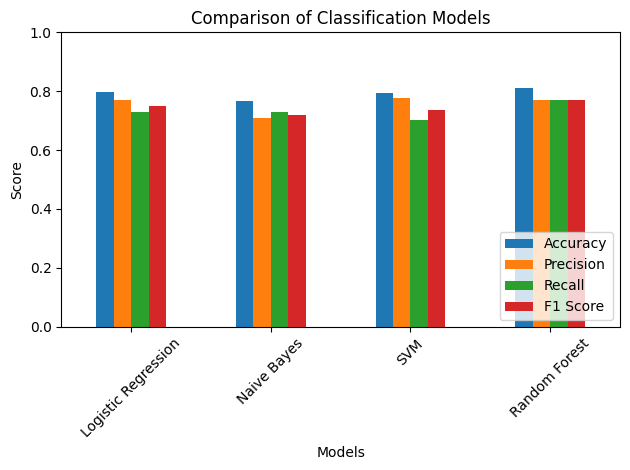

In [8]:

# Plotting the comparison of models
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar')
plt.title('Comparison of Classification Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('model_comparison.png', format='png', dpi=300)
plt.show()